# ResNet26(model.py)

In [ ]:
from __future__ import print_function
from input_data import *
import torch.nn as nn
from torch.autograd import Variable
from utils import *
import os
import math
import argparse #解析命令行参数
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
# from torch.utils.data.distributed import DistributedSampler


import random
from random import choice

from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorboardX import SummaryWriter
import logging
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels, stride=1,downsample=None, k=2):
        super(ResidualBlock,self).__init__()
        self.k = k
        # print(in_channels, self.k)
        self.in_channels = in_channels
        # print('init_in_channels:', self.in_channels)
        self.out_channels = out_channels * self.k
        self.bn1 =  nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3,padding=1)
        self.dropout = nn.Dropout(p = 0.2)
        self.bn3 = nn.BatchNorm2d(self.out_channels)
        self.conv3 = nn.Conv2d(self.out_channels, self.out_channels*4, kernel_size=1,stride=stride)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        # print("block conv1 size",x.size())
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        # print("block conv2 size",x.size())
        x = self.dropout(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3(x)
        # print("block conv3 size ",x.size())
        # print("bolck residual size",residual.size())
        # print("downsample ;",self.downsample)
        if self.downsample is not None:
            residual = self.downsample(residual)
        # print("x size",x.size())
        # print('residual size',residual.size())
        x += residual
        return  x

class ResNet(nn.Module):
    def __init__(self,ResidualBlock,layers,k=2, num_classes=5):
        self.k = 2
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.num_classes = num_classes
        self.stage1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, stride=1,padding=3),
            nn.MaxPool2d(kernel_size=2,stride=2),)
        self.stage2 = self._make_layer(ResidualBlock, 64, layers[0], stride=2)
        self.stage3 = self._make_layer(ResidualBlock, 128, layers[1], stride=2)
        self.stage4 = self._make_layer(ResidualBlock, 256, layers[2], stride=2)
        self.stage5 = self._make_layer(ResidualBlock, 512, layers[3], stride=1)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(2048*self.k, num_classes)
        self.classifier = nn.Softmax(1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

   # def _make_layer(self,block, out_channels, blocks, stride=1):
    def _make_layer(self, block, out_channels,blocks=1,stride=1):
        downsample = None
        # print('downsample: in_channel :',self.in_channels)
        # print("make layer downsample: ",downsample)
        # layers = []
        # layers.append(block(self.in_channels, out_channels, stride, downsample))
        # for i in range(1, blocks):
        #     layers.append(block(self.in_channels, out_channels))
        #     self.in_channels = out_channels
        # self.in_channels = out_channels
        # return nn.Sequential(*layers)
        layers = []
        downsample = None
        for i in range(0,blocks-1):
            if self.in_channels != out_channels * 4 * self.k:
                # print(out_channels*4*self.k)
                downsample = nn.Conv2d(self.in_channels, out_channels * 4 * self.k, kernel_size=1)
                # print('else')
            layers.append(block(self.in_channels, out_channels, stride=1, downsample=downsample))
            self.in_channels = out_channels * 4 * self.k

        downsample = None
        if stride != 1 :
            downsample = nn.MaxPool2d(kernel_size=1, stride=stride, )
        else:
            # print('else 2')
            pass
        layers.append(block(self.in_channels, out_channels, stride, downsample=downsample))
        self.in_channels = out_channels * 4 * self.k
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.stage1(x)
        # print("stage1 ",x.size())
        x = self.stage2(x)
        # print("stage2 size ",x.size())
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        self.classifier(x)

        return x

def Resnet26(pretrained=False,num_classes=5):
    model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=5)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

if __name__ == '__main__' :

    model = Resnet26()
    # input = torch.randn(10,3,64,64
    # print(train_dataset[0][0])
    print(type(test_dataset))
    input = test_dataset[0]
    input = Variable(input)
    output = model(input)
    print(output.size())

# data cleaning(choose_clean_sanmple.py)

In [ ]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def choose_clean_sample(dir):
    train_solution_df=pd.read_csv(dir)
    index_id = train_solution_df['GalaxyID']
    f_smooth = train_solution_df['Class1.1']
    f_completely_round = train_solution_df['Class7.1']
    f_in_between = train_solution_df['Class7.2']
    f_cigar_shaped = train_solution_df['Class7.3']
    f_features_disk = train_solution_df['Class1.2']
    f_edge_on_yes = train_solution_df['Class2.1']
    f_edge_on_no = train_solution_df['Class2.2']
    f_spiral_yes = train_solution_df['Class4.1']
    #print(index_id[0])
    # print(f_smooth.loc[0])
    # pprint.pprint(f_smooth)
    label = {}
    # label_id = {}
    for index in train_solution_df.index:
        if f_smooth.loc[index] >= 0.469 and f_completely_round.loc[index] >= 0.5:
         #   label.append([index, 0])
            label[index] = 0
        elif f_smooth.loc[index] >= 0.469 and f_in_between.loc[index] >= 0.5:
           # label.append([index, 1])
            label[index] = 1
        elif f_smooth.loc[index] >= 0.469 and f_cigar_shaped.loc[index] >= 0.5:
           # label.append([index, 2])
            label[index] = 2
        elif f_features_disk.loc[index] >= 0.430 and f_edge_on_yes.loc[index] >=0.602:
           # label.append([index, 3])
           label[index] = 3
        elif f_features_disk.loc[index] >= 0.430 and f_edge_on_no.loc[index] >= 0.715 and f_spiral_yes.loc[index] >= 0.619:
           # label.append([index, 4])
           label[index] = 4
        else:
            pass
  #  print(len(label))
    picture = []
    picture_label = []
    for key,value in label.items():
        key_id = index_id[key]
        # label_id[key_id] = value
        # print(len(label_id))
        picture.append('data/galaxy/images_training_rev1/'+str( key_id)+'.jpg ')
        picture_label.append(value)
    # draw = mpimg.imread('./'+ picture[0]) #读取图片
    # plt.imshow(draw)  # 显示图片
    # plt.axis('off')  # 不显示坐标轴
    # plt.show()
    data = {'root':picture,'label':picture_label,}
    f_data = pd.DataFrame(data)
    cols = f_data.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    f_data = f_data[cols]
    #print(f_data.head(3))
    #圆形星系
    data_round = f_data[f_data['label'] == 0]
    data_round = data_round.reset_index(drop=True)
    # print(data_round.shape)
    ind_list_r = list(range(data_round.shape[0]))
    ind_sample_r = random.sample(ind_list_r,round(data_round.shape[0]*0.9))
    # print("ind_sanmple_r : ",len(ind_sample_r)) #7592
    ind_rest_r = [x for x in ind_list_r if x not in ind_sample_r]
    # print("ind_rest_r : ", len(ind_rest_r))   # 844
    train_round = pd.DataFrame()
    test_round = pd.DataFrame()
    # print("data_round.index ",len(data_round.index))  #8436
    # print("data_round.index ",data_round.index)
    for index in ind_sample_r:
        train_round = train_round.append(data_round.loc[[index]], ignore_index=True)
    # print(" train_round ", train_round .shape)
    for index in ind_rest_r:
        test_round = test_round.append(data_round.loc[[index]], ignore_index=True)
    # drawname = test_round.to_string(header=False,index=False).split()[0]
    # print('drawname :'+drawname)
    # draw = mpimg.imread(drawname) #读取图片
    # plt.imshow(draw)  # 显示图片
    # plt.axis('off')  # 不显示坐标轴
    # plt.show()

    # print("test round ", test_round.shape)
    #middle
    data_middle = f_data[f_data['label'] == 1]
    data_middle = data_middle.reset_index(drop=True)
   # print(data_middle.shape)
    ind_list_m = list(range(data_middle.shape[0]))
    ind_sample_m = random.sample(ind_list_m,round(data_middle.shape[0]*0.9))
    ind_rest_m = [x for x in ind_list_m if x not in ind_sample_m]
    train_middle = pd.DataFrame()
    test_middle = pd.DataFrame()
    for index in ind_sample_m:
         train_middle = train_middle.append(data_middle.loc[[index]], ignore_index=True)
    for index in ind_rest_m:
         test_middle = test_middle.append(data_middle.loc[[index]], ignore_index=True)
   # print("middle ", test_middle.shape)
    #cigar
    data_cigar = f_data[f_data['label'] == 2]
    data_cigar = data_cigar.reset_index(drop=True)
    ind_list_c = list(range(data_cigar.shape[0]))
    ind_sample_c = random.sample(ind_list_c, round(data_cigar.shape[0] * 0.9))
    ind_rest_c = [x for x in ind_list_c if x not in ind_sample_c]
    train_cigar = pd.DataFrame()
    test_cigar = pd.DataFrame()
    for index in ind_sample_c:
        train_cigar = train_cigar.append(data_cigar.loc[[index]], ignore_index=True)
    for index in ind_rest_c:
        test_cigar = test_cigar.append(data_cigar.loc[[index]], ignore_index=True)
  #  print("cigar ", test_cigar.shape)
  #lateral
    data_lateral = f_data[f_data['label'] == 3]
    data_lateral = data_lateral.reset_index(drop=True)
    ind_list_l = list(range(data_lateral.shape[0]))
    ind_sample_l = random.sample(ind_list_l, round(data_lateral.shape[0]*0.9))
    ind_rest_l = [x for x in ind_list_l if x not in ind_sample_l]
    train_lateral = pd.DataFrame()
    test_lateral = pd.DataFrame()
    for index in ind_sample_l:
        train_lateral = train_lateral.append(data_lateral.loc[[index]], ignore_index=True)
    for index in ind_rest_l:
        test_lateral = test_lateral.append(data_lateral.loc[[index]], ignore_index=True)
   # print("lateral ",test_lateral.shape)
    # spiral
    data_spiral  = f_data[f_data['label'] == 4]
    data_spiral = data_spiral.reset_index(drop=True)
    ind_list_s = list(range(data_spiral.shape[0]))
    ind_sample_s = random.sample(ind_list_s, round(data_spiral.shape[0] * 0.9))
    ind_rest_s = [x for x in ind_list_s if x not in ind_sample_s]
    train_spiral = pd.DataFrame()
    test_spiral = pd.DataFrame()
    for index in ind_sample_s:
        train_spiral = train_spiral.append(data_spiral.loc[[index]], ignore_index=True)
    for index in ind_rest_s:
        test_spiral = test_spiral.append(data_spiral.loc[[index]], ignore_index=True)
   # print("spiral",test_spiral.shape)
   # print(data_spiral.head(3))
    train_clean_data = train_round.append([train_middle,train_cigar,train_lateral,train_spiral])
    train_clean_data = train_clean_data.sample(frac=1).reset_index(drop=True)
    test_clean_data = test_round.append([test_middle, test_cigar, test_lateral, test_spiral])
    test_clean_data = test_clean_data.sample(frac=1).reset_index(drop=True)
   # print('train ',train_clean_data.shape)
    print('test ', test_clean_data.shape)

#返回的f_data 是 dataframe，第一列叫‘root'，第二列叫"label"
    return train_clean_data, test_clean_data


if __name__ == '__main__':
    dir = 'data/galaxy/training_solutions_rev1/training_solutions_rev1.csv'
    train_clean_sample, test_clean_sample = choose_clean_sample(dir)
    filename1 = 'train_list.txt'
    filename2 = 'test_list.txt'
    train_clean_sample_str = train_clean_sample.to_string(header=False,index=False)
    test_clean_sample_str = test_clean_sample.to_string(header=False,index=False)
    with open(filename1,'w') as file:
        file.write(train_clean_sample_str)
    with open(filename2, 'w') as file:
        file.write(test_clean_sample_str)a

# Data_loader (input_data.py)

In [ ]:
from torchvision import transforms
    from PIL import Image
    import torch
    import numpy as np
    import math
    import random
    import cv2
    from model import *
    cv2.ocl.setUseOpenCL(False)
    from torch.utils.data import Dataset
    # from MLP import *

    class ResizeCV2(object):
        def __init__(self, new_width, new_height):
            self.new_width = new_width
            self.new_height = new_height

        def __call__(self, img):
            img_np = np.array(img)
            img_np = cv2.resize(img_np, (self.new_width, self.new_height))
            img = Image.fromarray(img_np)
            return img

    class McDataset(Dataset):
        def __init__(self, root_dir, meta_file, transform=None, output_index=False):
            self.root_dir = root_dir
            self.transform = transform
            with open(meta_file) as f:
                lines = f.readlines()
            print("building dataset from %s" % meta_file)
            self.num = len(lines)
            self.metas = []
            for line in lines:
                path, cls = line.rstrip().split()
                self.metas.append((path, int(cls)))
            print("read meta done")
            self.initialized = False
            self.output_index = output_index

        def __len__(self):
            return self.num

        def __getitem__(self, idx):
            filename = self.root_dir + '/' + self.metas[idx][0]
            cls = self.metas[idx][1]
            img = Image.open(filename)
            ## transform
            origin_img = (np.array(transforms.ToTensor()(img)).transpose((1,2,0)).copy()*255).astype(np.int32)
            cv2.imwrite('origin.jpg', origin_img)
            if self.transform is not None:
                img = self.transform(img)
            change_img = (np.array(img).transpose((1,2,0)).copy()*255).astype(np.int32)
            cv2.imwrite('change.jpg', change_img)
            if self.output_index:
                return img, cls, idx
            else:
                return img, cls

    class White(object):
        def __init__(self):
            pass
        def __call__(self, img):
            # print('img:', img)
            size = img.size()
            # print(size[0])
            img = img.view(size[0], -1)
            #print(img.size())
            eps = torch.ones(size[0],1)*(1/math.sqrt(size[1]))
            # print(eps.size())
            # print('img:', img)
            mean = torch.mean(img, dim=1, keepdim=True)
            #print('mean:', mean.size())
            std_tmp = torch.cat((torch.std(img, dim=1, keepdim=True), eps), dim=0)
            # print(torch.cat((torch.std(img, dim=0, keepdim=True), eps), dim=0).size())
            std = torch.max(std_tmp, dim=0)[0].expand_as(mean)
            # std = max(torch.std(img, dim=0, keepdim=True), eps)
            #print('std:', std.size())
            img = (img - mean) / std
            img = img.view(size[0], size[1], size[2])
            # print(img.size())
            return img

    if __name__ == '__main__':
        filename = 'test_list.txt'
        test_dataset = McDataset(
            '.',
            filename,
            transforms.Compose([
                transforms.CenterCrop((170, 240)),
                ResizeCV2(80, 80),
                transforms.RandomCrop((64, 64)),
                transforms.RandomRotation(90 * random.randint(0, 4)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.5, contrast=0.8, saturation=0, hue=0),
                transforms.ToTensor(),
                White(),
            ]))

        # print(train_dataset[0][0])
        input = test_dataset[0][0]
        print(input.size())
        input = input.reshape(1,3,64,64)
        input = Variable(input)
        model = Resnet26()

        checkpoint = torch.load('checkpoint/_204.pth.tar')
        net = Resnet26()
        # net.load_state_dict(checkpoint['state_dict'])
        own_state = net.state_dict()
        state_dict = checkpoint['state_dict']
        # print(own_state.keys())
        for name, param in state_dict.items():
            name = 'module.' + name
            # print(name)
            if name in own_state:
                # print('here')
                if isinstance(param, torch.nn.Parameter):  # isinstance函数来判断一个对象是否是一个已知的类型
                    # backwards compatibility for serialized parameters
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    print('While copying the parameter named {}, '
                          'whose dimensions in the model are {} and '
                          'whose dimensions in the checkpoint are {}.'
                          .format(name, own_state[name].size(), param.size()))
                    print("But don't worry about it. Continue pretraining.")

        output = model(input)
        # print(output.size())

# traning

   204个epoch左右达最高精确度

In [ ]:
def train(epoch):
    model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
    if epoch%args.decay_epoch == 0:
        adjust_learning_rate(optimizer, decay_rate=args.decay_rate)

    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data,target = Variable(data),Variable(target)

# Variable类对Tensor对象进行封装，会保存该张量对应的梯度，以及对生成该张量的函数grad_fn的一个引用。
#         print("data.size : ",data.size())  # (64,1,28,28)
       # data = data.view(-1, 28,28)
       # print(target.size())
        optimizer.zero_grad()   # zero the gradient buffers，必须要置零
        output = model(data)
        #print('data',data.size())
        #print('output', output.size())
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        #print(output.data)
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        #print(pred)
        #print('predsize',pred.size())
        # output是（64，10）的tensor，pred.size是[64]
        acc = []
        recall = []
        correct = pred.eq(target.data)  #如果预测正确，correct加一
        #print(target.data.size())
        for i in range(5): #5 class
            class_tmp = torch.ones(target.data.size()[0])*i
            class_tmp = class_tmp.long()
            class_index = target.data.cpu().eq(class_tmp)
            #print(pred[pred == i].size())
            if pred[pred == i].size()[0]:
                #print(correct[class_index.cuda().byte()==1].sum())
                #print(pred[pred == i].size()[0])
                acc.append(float(correct[class_index.cuda().byte()==1].sum())/(pred[pred == i].size()[0])) # 准确率
            else:
                acc.append(0)

            #print(pred[pred == i].sum())
            #print(pred[pred == i])
            #print(target.data[target.data == i].sum())
            if target.data[target.data == i].size()[0]:
                recall.append(float(correct[class_index.cuda().byte()==1].sum())/(target.data[target.data == i].size()[0])) # 召回率
            else:
                recall.append(0)

        #print('acc', acc, 'recall', recall)
       
        
        curr_step = epoch*len(train_loader)/args.batch_size + batch_idx
        tb_logger.add_scalar('acc0_train', acc[0], curr_step)
        tb_logger.add_scalar('acc1_train', acc[1], curr_step)
        tb_logger.add_scalar('acc2_train', acc[2], curr_step)
        tb_logger.add_scalar('acc3_train', acc[3], curr_step)
        tb_logger.add_scalar('acc4_train', acc[4], curr_step)
        tb_logger.add_scalar('loss', loss.data, curr_step)
        #tb_logger.add_scalar('lr', , curr_step)
        logger.info('Loss:{loss}, curr_step:{curr_step}, accuracy:{acc}, recall:{recall}'.format(loss=loss, curr_step=curr_step, acc=acc, recall=recall))
		
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))


# testing

最高精确率为96%.

In [ ]:
def test(epoch):
    model.eval()  # 把module设置为评估模式，只对Dropout和BatchNorm模块有影响
    test_loss = 0
    correct_num = 0
    acc, recall, pred_num, target_num = [0]*5, [0]*5, [0]*5, [0]*5

    for batch_idx, (data, target) in enumerate(test_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        # volatile=true 排除子图 让test数据不参与梯度的计算,加速测试;
        # volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
       # data = data.view(-1, 28,28)
        output = model(data)
        #print('output', output)
        test_loss += F.cross_entropy(output, target).data[0]  # Variable.data
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        #print('pred', pred)
        #print('predsize',pred.size())
        # output是（64，10）的tensor，pred.size是[64]
        correct_num += pred.eq(target.data).cpu().sum()  #如果预测正确，correct加一

        correct = pred.eq(target.data)  #如果预测正确，correct加一
        #print(target.data.size())
        for i in range(5): #5 class
            class_tmp = torch.ones(target.data.size()[0])*i
            class_tmp = class_tmp.long()
            class_index = target.data.cpu().eq(class_tmp)
            #print(pred[pred == i].size())
            #print(correct[class_index.cuda().byte()==1].sum())
            #print(pred[pred == i].size()[0])
            acc[i] += float(correct[class_index.cuda().byte()==1].sum())
            pred_num[i] += pred[pred == i].size()[0]

            #print(pred[pred == i].sum())
            #print(pred[pred == i])
            #print(target.data[target.data == i].sum())
            recall[i] += float(correct[class_index.cuda().byte()==1].sum())
            target_num[i] += target.data[target.data == i].size()[0]
    print(acc, recall, pred_num, target_num)
    for i in range(len(acc)):
        if pred_num[i]:
            acc[i] = acc[i]/pred_num[i]
        else:
            acc[i] = 0
        recall[i] = recall[i]/target_num[i]
    test_loss = test_loss
    test_loss /= len(test_loader)  # loss function already averages over batch size
    logger.info('\nTest set: Average loss: {:.4f}, AccuracyofAll: {}/{} ({:.0f}%), acc:{acc}, recall:{recall}\n'.format(
        test_loss, correct_num, len(test_loader.dataset),
        100. * correct_num / len(test_loader.dataset), acc=acc, recall=recall))
    print('\nTest set: Average loss: {:.4f}, AccuracyofAll: {}/{} ({:.4f}%), acc:{acc}, recall:{recall}\n'.format(
        test_loss, correct_num, len(test_loader.dataset),
        100. * correct_num / len(test_loader.dataset), acc=acc, recall=recall))

# show the classification

In [38]:
# %load predict.py
from torchvision import transforms
from PIL import Image
import matplotlib.image as mpimg
import torch
import numpy as np
import math
import random
import cv2
from model import *
cv2.ocl.setUseOpenCL(False)
from torch.utils.data import Dataset
#import matplotlib.image as mpimg
# from MLP import *

class ResizeCV2(object):
    def __init__(self, new_width, new_height):
        self.new_width = new_width
        self.new_height = new_height

    def __call__(self, img):
        img_np = np.array(img)
        img_np = cv2.resize(img_np, (self.new_width, self.new_height))
        img = Image.fromarray(img_np)
        return img

class McDataset(Dataset):
    def __init__(self, root_dir, meta_file, transform=None, output_index=False):
        self.root_dir = root_dir
        self.transform = transform
        with open(meta_file) as f:
            lines = f.readlines()
        print("building dataset from %s" % meta_file)
        self.num = len(lines)
        self.metas = []
        for line in lines:
            path, cls = line.rstrip().split()
            self.metas.append((path, int(cls)))
        print("read meta done")
        self.initialized = False
        self.output_index = output_index

    def __len__(self):
        return self.num

    def __getitem__(self, idx):
        filename = self.root_dir + '/' + self.metas[idx][0]
        cls = self.metas[idx][1]
        img = Image.open(filename)
        ## transform
        origin_img = (np.array(transforms.ToTensor()(img)).transpose((1,2,0)).copy()*255).astype(np.int32)
        cv2.imwrite('origin.jpg', origin_img)
        if self.transform is not None:
            img = self.transform(img)
        change_img = (np.array(img).transpose((1,2,0)).copy()*255).astype(np.int32)
        cv2.imwrite('change.jpg', change_img)
        if self.output_index:
            return img, cls, idx
        else:
            return img, cls, filename

class White(object):
    def __init__(self):
        pass
    def __call__(self, img):
        # print('img:', img)
        size = img.size()
        # print(size[0])
        img = img.view(size[0], -1)
        #print(img.size())
        eps = torch.ones(size[0],1)*(1/math.sqrt(size[1]))
        # print(eps.size())
        # print('img:', img)
        mean = torch.mean(img, dim=1, keepdim=True)
       # print('mean:', mean.size())
        std_tmp = torch.cat((torch.std(img, dim=1, keepdim=True), eps), dim=0)
        # print(torch.cat((torch.std(img, dim=0, keepdim=True), eps), dim=0).size())
        std = torch.max(std_tmp, dim=0)[0].expand_as(mean)
        # std = max(torch.std(img, dim=0, keepdim=True), eps)
        #print('std:', std.size())
        img = (img - mean) / std
        img = img.view(size[0], size[1], size[2])
        # print(img.size())
        return img

if __name__ == '__main__':
    filename = 'test_list.txt'
    test_dataset = McDataset(
        '.',
        filename,
        transforms.Compose([
            transforms.CenterCrop(220),
            ResizeCV2(80, 80),
            transforms.CenterCrop((64, 64)),
            transforms.ToTensor(),
            White(),
        ]))

    # print(train_dataset[0][0])
    num = random.randint(0, 2880)
    print('select picture randomly：',num)
    input = test_dataset[num][0]
    img,cls,root =test_dataset.__getitem__(num)
    input = input.reshape(1,3,64,64)
    input = Variable(input)
    model = Resnet26()
    cls = int(cls)
    if cls == 0:
        clsname = 'round'
    elif cls == 1:
        clsname = 'middle'
    elif cls == 2:
        clsname = 'cigar'
    elif cls == 3:
        clsname = 'lateral'
    else:
        clsname = 'spiral'
    checkpoint = torch.load('checkpoint/_204.pth.tar')
    state_dict = checkpoint['state_dict']
    own_state = model.state_dict()
 #   print(own_state.keys())
    for name, param in state_dict.items():
       # name = 'module.'+name
        name = name[7:]
    #    print(name)
        if name in own_state:
       #     print('here')
            if isinstance(param, torch.nn.Parameter):  # isinstance函数来判断一个对象是否是一个已知的类型
                # backwards compatibility for serialized parameters
                param = param.data
            try:
                own_state[name].copy_(param)
#                print('here')
            except Exception:
                print('While copying the parameter named {}, '
                      'whose dimensions in the model are {} and '
                      'whose dimensions in the checkpoint are {}.'
                      .format(name, own_state[name].size(), param.size()))
                print("But don't worry about it. Continue pretraining.")
    output = model(input)
    pred = output.data.max(1)[1]
    pred = int(pred)
    # print(output.size())
    if pred == 0:
        predname = 'round'
    elif pred == 1:
        predname = 'middle'
    elif pred == 2:
        predname = 'cigar'
    elif pred == 3:
        predname = 'lateral'
    else:
        predname = 'spiral'
#     draw = mpimg.imread(root)
#     plt.imshow(draw)  # 显示图片
#     plt.axis('off')  # 不显示坐标轴
#     plt.title('true label: '+clsname+' prediction: '+ predname)
#     plt.show()

    # print(output.size())


building dataset from test_list.txt
read meta done
select picture randomly： 1361


galaxy ID :  819506
true label:  4
predict 4


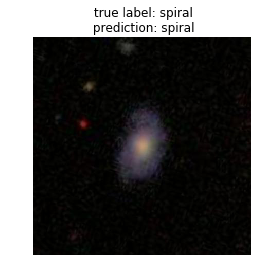

In [39]:
print('galaxy ID : ',root[35:41])
print('true label: ',cls)
print('predict',int(pred))
draw = mpimg.imread(root)
plt.imshow(draw)  
plt.axis('off')  
plt.title(' true label: '+clsname+'\n prediction: '+ predname)
plt.show()